<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/algorithm/sort_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
%reset -f

## ハンガリアン法

A=


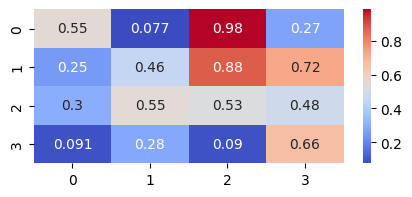

In [40]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 表示の精度を設定
np.set_printoptions(precision=3, suppress=False)
plt.rcParams['figure.figsize'] = (5, 2)

N = 4
A = np.random.rand(N, N)
print("A=")
sns.heatmap(A, annot=True, cmap='coolwarm')
plt.show()

https://qiita.com/m__k/items/8e2cb9067ec5d720c30d

In [41]:
import numpy as np

def step1(mat_):
  mat = mat_.copy()
  # 各行の最小値を引く
  row_min = np.min(mat, axis=1)[:, np.newaxis]
  mat = mat - row_min
  # 各列の最小値を引く
  col_min = np.min(mat, axis=0)
  mat = mat - col_min
  return mat

def step2(mat):
  # 値が 0 の成分のインデックスを取得
  row_idxs, col_idxs = np.where(mat == 0)
  zero_idxs = np.array([row_idxs, col_idxs]).T
  # 0 成分を含む行・列を重複なく・不足なく選択できるか
  check_row, checl_col = [], []
  for elem in zero_idxs:
    if not elem[0] in check_row and not elem[1] in checl_col:
      check_row.append(elem[0])
      checl_col.append(elem[1])
  success = (len(check_row) == mat.shape[0])
  return success, zero_idxs

def step3(mat, zero_idxs):
  zero_list = zero_idxs
  zero_count = {}
  line = []
  # 行・列ごとに 0 の数をカウント
  while(len(zero_list) > 0):
    for elem in zero_list:
      r = f"r_{elem[0]}"
      c = f"c_{elem[1]}"
      zero_count[r] = zero_count[r] + 1 if r in zero_count else 1
      zero_count[c] = zero_count[c] + 1 if c in zero_count else 1

    # 最も多い行・列を選択
    max_zero = max(zero_count.items(), key=lambda x: x[1])[0]
    line.append(max_zero)

    # インデックスの番号を取得
    rc, num = max_zero.split("_")
    if rc == 'r':
      zero_list = [v for v in zero_list if str(v[0]) != num]
    else:
      zero_list = [v for v in zero_list if str(v[1]) != num]

    # クリア
    zero_count = {}
  return line

def step4(mat, line):
  output_mat = np.zeros_like(mat)
  line_r = []
  line_c = []
  for l in line:
    rc = l.split("_")[0]
    num = int(l.split("_")[1])
    if rc == 'r':
      line_r.append(num)
    else:
      line_c.append(num)

  # step 3 の行・列を削除
  line_cut_mat = np.delete(np.delete(mat, line_r, 0), line_c,1)
  # 残りの要素で最も小さいもの
  mini = np.min(line_cut_mat)

  # 縦・横の線の交差点
  cross_point = [(i,j) for i in line_r for j in line_c]
  # 縦・横の線にかからない要素
  non_line_point = [
      (i,j)
      for i in range(0, mat.shape[0])
      for j in range(0, mat.shape[1])
      if i not in line_r if j not in line_c]

  for pt in cross_point:
    # 縦横の線が交わる点
    mat[pt] += mini
  for pt in non_line_point:
    # 残りの要素
    mat[pt] -= mini
  return mat

def hungarian(mat):
  mat = step1(mat)
  mat = step1(mat.T).T
  while(True):
    flag, zero_coordinate = step2(mat)
    if flag: break
    line = step3(mat, zero_coordinate)
    mat = step4(mat, line)

  r, c, optimal = [], [], []
  for v in zero_coordinate:
    if v[0] not in r and v[1] not in c:
      optimal.append(v)
      r.append(v[0])
      c.append(v[1])
  return optimal

optimal = hungarian(A)
print(optimal)

[array([0, 1]), array([1, 0]), array([2, 3]), array([3, 2])]


## 二重振り子のトラッキング

二重振り子のソルバー

In [42]:
import numpy as np

def dp_fmap(x: np.ndarray, dt: float):
    theta1, theta2, p1, p2 = x
    cos = np.cos(theta1 - theta2)
    sin = np.sin(theta1 - theta2)

    d_theta1 = (p1 - cos * p2) / (2-cos)
    d_theta2 = -cos + 2 * p2 / (2-cos)

    g = 9.8
    d_p1 = -sin * d_theta1 * d_theta2 - 2 * g * np.sin(theta1)
    d_p2 = sin * d_theta1 * d_theta2 - g * np.sin(theta2)

    theta1_next = theta1 + d_theta1 * dt
    theta2_next = theta2 + d_theta2 * dt
    p1_next = p1 + d_p1 * dt
    p2_next = p2 + d_p2 * dt

    return np.array([theta1_next, theta2_next, p1_next, p2_next])

def dp_hmap(x: np.ndarray):
    # 運動量は使用しない
    theta1, theta2, _, _ = x

    x1 = np.sin(theta1)
    y1 = -np.cos(theta1)
    x2 = x1 + np.sin(theta2)
    y2 = y1 - np.cos(theta2)

    return np.array([x1, y1, x2, y2])

軌跡生成

In [43]:
dt = 0.02
times = np.arange(0, 10, dt)

# 真の軌跡
x_list = [np.array([np.pi/2, np.pi/2, 0, 0])]
for t in times:
    x_list.append(dp_fmap(x_list[-1], dt))
x_list = np.vstack(x_list)

# (x1, x2, p1, p2) のノイズ
noise_sigma = 0.4
noise = np.random.normal(0, noise_sigma**2, (len(x_list), 4))

x_list = np.array([dp_hmap(x) for i, x in enumerate(x_list)])
obs_list = np.array([x + noise[i] for i, x in enumerate(x_list)])

パレット作成

In [44]:
from matplotlib.colors import TABLEAU_COLORS

blue = TABLEAU_COLORS["tab:blue"]
orange = TABLEAU_COLORS["tab:orange"]
green = TABLEAU_COLORS["tab:green"]
red = TABLEAU_COLORS["tab:red"]
purple = TABLEAU_COLORS["tab:purple"]

In [45]:
%%capture
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.set_aspect('equal')
ax.set_xlim(-2.3, 2.3)
ax.set_ylim(-2.3, 1.5)

traj_plt, = ax.plot([], [], c=blue, label="Trajectory")
cur_pos_plt, = ax.plot(
    [], [], c=orange, marker="o", markersize=5,
    label="Current Position")
obs_pos_scat = ax.scatter([], [], s=5, c=red, label="Observation")
ax.legend(loc="upper right", fontsize="x-small")

プロット

In [46]:
from matplotlib.patches import Ellipse
import matplotlib.animation as animation

# 観測誤差範囲
obs_ellipse = Ellipse(
    xy=(0, 1), width=noise_sigma, height=noise_sigma, angle=0,
    color=red, alpha=0.1, animated=True)
ax.add_patch(obs_ellipse)

def anim_callback(i):

    ax.set_title(f"Frame {i}")

    traj_plt.set_data(x_list[:i, 2], x_list[:i, 3])
    cur_pos_plt.set_data(
        [0, *x_list[i, [0, 2]]], [0, *x_list[i, [1, 3]]])

    # 観測点
    obs_pos_scat.set_offsets(obs_list[:i+1, [2, 3]])
    obs_ellipse.set_center(obs_list[i, [2, 3]])

skip = 4
ani = animation.FuncAnimation(
    fig, anim_callback, frames=range(0, len(obs_list), skip))
ani.save("dp.gif", writer="pillow")

描画

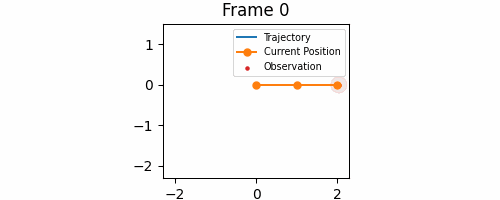

In [47]:
import IPython
from IPython.display import Image

Image("./dp.gif", format='png')